# Combined  Model (XGBoost Undersampling + XGBoost Regression)

We developed a hybrid model using both xgboost regression and xgboost classification(while undersampling technique was implemented to enhance its performance). Subsequently, we evaluated the performance of this combined model on the test dataset and compared it with the result of the simple xgboost regression model. 

###The whole code is in a loop to have an m average of RMSE estimation.


In [1]:
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shap
import imblearn
import statsmodels.api as sm
import statistics

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBClassifier
from sty import fg, rs

from sklearn.metrics import confusion_matrix
from matplotlib import cm
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from utils import get_training_dataset

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [4]:
num_exp = 100
bins = 6
# Define empty list to save RMSE in combined model

test_RMSE_lst = np.zeros(num_exp)
test_RMSE_bin = np.zeros((num_exp, bins))

# Define empty list to save RMSE in model1

test_RMSE_lst_M1 = np.zeros(num_exp)
test_RMSE_bin_M1 = np.zeros((num_exp, bins))


for new_run in range(100):

    df = get_training_dataset()
    df["rwi"].fillna(df["rwi"].mean(), inplace=True)

    # Set any values >100% to 100%,
    for r in range(len(df)):
        if df.loc[r, "percent_houses_damaged"] > 100:
            df.at[r, "percent_houses_damaged"] = float(100)

    df = (df[(df[["wind_speed"]] != 0).any(axis=1)]).reset_index(drop=True)
    df = df.drop(columns=["grid_point_id", "typhoon_year"])

    # Define bins for data stratification
    bins2 = [0, 0.00009, 1, 10, 50, 101]
    bins_eval = [0, 1, 10, 20, 50, 101]
    samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)

    bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)
    y_input_strat = bin_index2

    features = [
        "wind_speed",
        "track_distance",
        "total_houses",
        "rainfall_max_6h",
        "rainfall_max_24h",
        "rwi",
        "mean_slope",
        "std_slope",
        "mean_tri",
        "std_tri",
        "mean_elev",
        "coast_length",
        "with_coast",
        "urban",
        "rural",
        "water",
        "total_pop",
        "percent_houses_damaged_5years",
    ]

    # Split X and y from dataframe features
    X = df[features]
    y = df["percent_houses_damaged"]

    # Define train and test data
    X_train, X_test, y_train, y_test = train_test_split(
        X, df["percent_houses_damaged"], test_size=0.2, stratify=y_input_strat
    )

    # XGBoost Reduced Overfitting
    xgb = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=0,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_test, y_test)]
    xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    # Make prediction on train and test data
    y_pred_train = xgb.predict(X_train)
    y_pred = xgb.predict(X_test)

    # Calculate RMSE in total
    mse_train_idx = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train_idx)

    mse_idx = mean_squared_error(y_test, y_pred)
    rmseM1 = np.sqrt(mse_idx)

    # Add total RMSE of Model1 to the list
    test_RMSE_lst_M1[new_run] = rmseM1

    # Calculate RMSE per bins
    bin_index_test = np.digitize(y_test, bins=bins_eval)
    bin_index_train = np.digitize(y_train, bins=bins_eval)

    RSME_test_model1 = np.zeros(len(bins_eval) - 1)

    for bin_num in range(1, len(bins_eval)):

        # Estimation of RMSE for train data
        mse_train_idx = mean_squared_error(
            y_train[bin_index_train == bin_num],
            y_pred_train[bin_index_train == bin_num],
        )
        rmse_train = np.sqrt(mse_train_idx)

        # Estimation of RMSE for test data
        mse_idx = mean_squared_error(
            y_test[bin_index_test == bin_num], y_pred[bin_index_test == bin_num]
        )
        RSME_test_model1[bin_num - 1] = np.sqrt(mse_idx)

        # Add RMSE of Model1 to the list of each bin
        test_RMSE_bin_M1[new_run, bin_num] = RSME_test_model1[bin_num - 1]

    ## Second step is to train XGBoost Binary model for same train data

    # Define a threshold to separate target into damaged and not_damaged
    thres = 10.0
    y_test_bool = y_test >= thres
    y_train_bool = y_train >= thres
    y_test_bin = (y_test_bool) * 1
    y_train_bin = (y_train_bool) * 1

    sum(y_train_bin)

    # Undersampling

    # Define undersampling strategy
    under = RandomUnderSampler(sampling_strategy=0.1)
    # Fit and apply the transform
    X_train_us, y_train_us = under.fit_resample(X_train, y_train_bin)

    # Use XGBClassifier as a Machine Learning model to fit the data
    xgb_model = XGBClassifier(eval_metric=["error", "logloss"])

    # eval_set = [(X_train, y_train), (X_train, y_train)]
    eval_set = [(X_test, y_test_bin)]
    xgb_model.fit(
        X_train_us,
        y_train_us,
        eval_set=eval_set,
        verbose=False,
    )

    # Make prediction on test data and print Confusion Matrix
    y_pred_test = xgb_model.predict(X_test)
    cm = confusion_matrix(y_test_bin, y_pred_test)

    # Make prediction on train data and print Confusion Matrix
    y_pred_train = xgb_model.predict(X_train)
    cm = confusion_matrix(y_train_bin, y_pred_train)

    reduced_df = X_train.copy()

    reduced_df["percent_houses_damaged"] = y_train.values
    reduced_df["predicted_value"] = y_pred_train

    fliterd_df = reduced_df[reduced_df.predicted_value == 1]

    ### Third step is to train XGBoost regression model for this reduced train data (including damg>10.0%)

    # Define bins for data stratification in regression model
    bins2 = [0, 1, 10, 20, 50, 101]
    samples_per_bin2, binsP2 = np.histogram(
        fliterd_df["percent_houses_damaged"], bins=bins2
    )
    bin_index2 = np.digitize(fliterd_df["percent_houses_damaged"], bins=binsP2)
    y_input_strat = bin_index2

    # Split X and y from dataframe features
    X_r = fliterd_df[features]
    y_r = fliterd_df["percent_houses_damaged"]

    # XGBoost Reduced Overfitting
    xgbR = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=0,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_r, y_r)]
    xgbR_model = xgbR.fit(X_r, y_r, eval_set=eval_set, verbose=False)

    # Make prediction on train and global test data
    y_pred_r = xgbR.predict(X_r)
    y_pred_test_total = xgbR.predict(X_test)

    # Calculate RMSE in total

    mse_train_idxR = mean_squared_error(y_r, y_pred_r)
    rmse_trainR = np.sqrt(mse_train_idxR)

    mse_idxR = mean_squared_error(y_test, y_pred_test_total)
    rmseR = np.sqrt(mse_idxR)

    # Calculate RMSE per bins
    bin_index_r = np.digitize(y_r, bins=bins_eval)

    RSME_test_model1R = np.zeros(len(bins_eval) - 1)
    for bin_num in range(1, len(bins_eval)):

        # Estimation of RMSE for train data
        mse_train_idxR = mean_squared_error(
            y_r[bin_index_r == bin_num], y_pred_r[bin_index_r == bin_num]
        )
        rmse_trainR = np.sqrt(mse_train_idxR)

        # Estimation of RMSE for test data
        mse_idxR = mean_squared_error(
            y_test[bin_index_test == bin_num],
            y_pred_test_total[bin_index_test == bin_num],
        )
        RSME_test_model1R[bin_num - 1] = np.sqrt(mse_idxR)

    #### Last step is to add model combination (model M1 with model MR)
    # Check the result of classifier for test set
    reduced_test_df = X_test.copy()

    # joined X_test with countinous target and binary predicted values
    reduced_test_df["percent_houses_damaged"] = y_test.values
    reduced_test_df["predicted_value"] = y_pred_test

    # damaged prediction
    fliterd_test_df1 = reduced_test_df[reduced_test_df.predicted_value == 1]

    # not damaged prediction
    fliterd_test_df0 = reduced_test_df[reduced_test_df.predicted_value == 0]

    # Use X0 and X1 for the M1 and MR models' predictions
    X1 = fliterd_test_df1[features]
    X0 = fliterd_test_df0[features]

    # For the output equal to 1 apply MR to evaluate the performance
    y1_pred = xgbR.predict(X1)
    y1 = fliterd_test_df1["percent_houses_damaged"]

    # For the output equal to 0 apply M1 to evaluate the performance
    y0_pred = xgb.predict(X0)
    y0 = fliterd_test_df0["percent_houses_damaged"]

    fliterd_test_df0["predicted_percent_damage"] = y0_pred
    fliterd_test_df1["predicted_percent_damage"] = y1_pred

    # Join two dataframes together
    join_test_dfs = pd.concat([fliterd_test_df0, fliterd_test_df1])

    # Calculate RMSE in total
    mse_combined_model = mean_squared_error(
        join_test_dfs["percent_houses_damaged"],
        join_test_dfs["predicted_percent_damage"],
    )
    rmse_combined_model = np.sqrt(mse_combined_model)
    test_RMSE_lst[new_run] = rmse_combined_model

    # Calculate RMSE per bin
    y_join = join_test_dfs["percent_houses_damaged"]
    y_pred_join = join_test_dfs["predicted_percent_damage"]

    bin_index_test = np.digitize(y_join, bins=bins_eval)
    RSME_combined_model = np.zeros(len(bins_eval) - 1)

    for bin_num in range(1, len(bins_eval)):

        mse_combined_model_bin = mean_squared_error(
            y_join[bin_index_test == bin_num],
            y_pred_join[bin_index_test == bin_num],
        )
        RSME_combined_model = np.sqrt(mse_combined_model_bin)
        test_RMSE_bin[new_run, bin_num] = RSME_combined_model

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value 

In [5]:
# Compare total RMSEs of Combined model with M1 model
combined_test_rmse = statistics.mean(test_RMSE_lst)
m1_test_rmse = statistics.mean(test_RMSE_lst_M1)

print(f"mean_RMSE_test_M1_model: {m1_test_rmse:.2f}")
print(f"mean_RMSE_test_Combined_model: {combined_test_rmse:.2f}")

mean_RMSE_test_M1_model: 3.25
mean_RMSE_test_Combined_model: 3.28


In [7]:
# Compare RMSE per bin between Combined model with M1 model
combined_test_rmse_bin = np.mean(test_RMSE_bin, axis=0)
m1_test_rmse_bin = np.mean(test_RMSE_bin_M1, axis=0)

for bin_num in range(1, 6):

    print(f"RMSE per bin {bin_num}")
    print(f"mean_RMSE_test_Combined_model: {combined_test_rmse_bin[bin_num]:.2f}")
    print(f"mean_RMSE_test_M1_model: {m1_test_rmse_bin[bin_num]:.2f}\n")

RMSE per bin 1
mean_RMSE_test_Combined_model: 1.44
mean_RMSE_test_M1_model: 1.13

RMSE per bin 2
mean_RMSE_test_Combined_model: 5.82
mean_RMSE_test_M1_model: 4.79

RMSE per bin 3
mean_RMSE_test_Combined_model: 9.34
mean_RMSE_test_M1_model: 9.98

RMSE per bin 4
mean_RMSE_test_Combined_model: 16.77
mean_RMSE_test_M1_model: 18.79

RMSE per bin 5
mean_RMSE_test_Combined_model: 35.21
mean_RMSE_test_M1_model: 36.92



In [8]:
# Define a function to plot RMSEs
def rmse_bin_plot(M1_rmse, combined_rmse, min_rg, max_rg, step):

    plt.figure(figsize=(4, 3))
    plt.axvline(M1_rmse, color="red", linestyle="dashed")
    plt.hist(
        M1_rmse,
        bins=np.arange(min_rg, max_rg, step),
        edgecolor="k",
        histtype="bar",
        density=True,
    )

    plt.axvline(combined_rmse, color="b", linestyle="dashed")
    plt.hist(
        combined_rmse,
        bins=np.arange(min_rg, max_rg, step),
        color="orange",
        edgecolor="k",
        histtype="bar",
        density=True,
        alpha=0.7,
    )

    print(f"mean_RMSE_test: {M1_rmse:.2f}")
    print(f"mean_RMSE_train: {combined_rmse:.2f}")

    # create legend
    labels = ["Mean_M1", "Mean_combined", "M1", "Combined"]
    plt.legend(labels)

    plt.xlabel("The RMSE error")
    plt.ylabel("Frequency")
    plt.title("histogram of the RMSE distribution")
    plt.show()

RMSE in total 

mean_RMSE_test: 3.25
mean_RMSE_train: 3.28


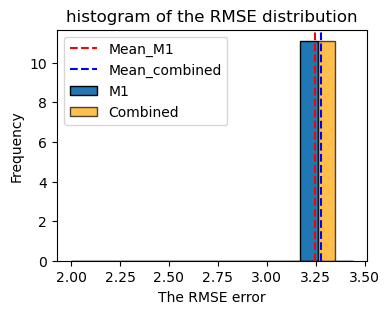

In [9]:
print("RMSE in total", "\n")
rmse_bin_plot(m1_test_rmse, combined_test_rmse, 2.0, 3.5, 0.09)

RMSE per bin 1

mean_RMSE_test: 1.13
mean_RMSE_train: 1.44


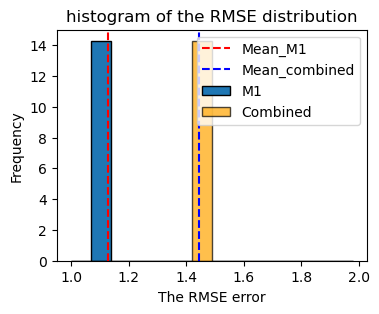

RMSE per bin 2

mean_RMSE_test: 4.79
mean_RMSE_train: 5.82


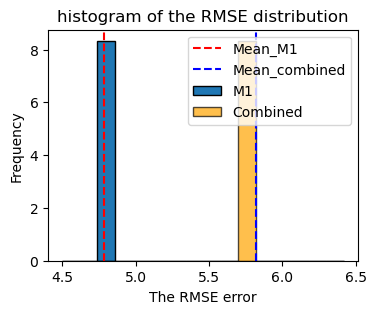

RMSE per bin 3

mean_RMSE_test: 9.98
mean_RMSE_train: 9.34


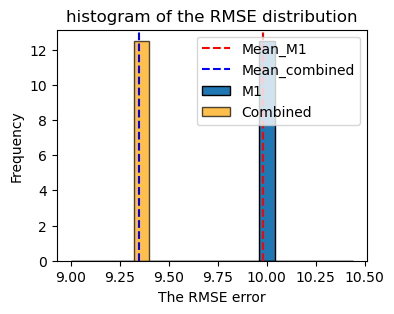

RMSE per bin 4

mean_RMSE_test: 18.79
mean_RMSE_train: 16.77


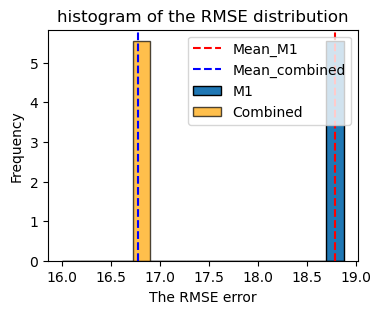

RMSE per bin 5

mean_RMSE_test: 36.92
mean_RMSE_train: 35.21


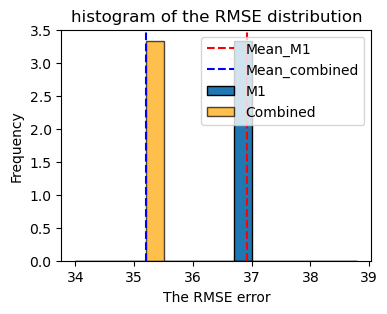

In [12]:
bin_params = {
    1: (1.0, 2.0, 0.07),
    2: (4.5, 6.5, 0.12),
    3: (9.0, 10.5, 0.08),
    4: (16.0, 19.0, 0.18),
    5: (34.0, 39.0, 0.3),
}


for bin_num in range(1, 6):

    print(f"RMSE per bin {bin_num}\n")
    rmse_bin_plot(
        m1_test_rmse_bin[bin_num], combined_test_rmse_bin[bin_num], *bin_params[bin_num]
    )